***
<center> <h1>Multiple Target Spectra Ground Motion Selection Tool</h1> </center>

***
<center> <h4>Last modified: March 2022</h4> </center>

This is a sample Jupyter notebook developed by <a href="mailto:mshokrabadi@ucla.edu">Mehrdad Shokrabadi</a> and <a href="mailto:askari@ucla.edu">Mohammad Askari</a> to show how to use this tool for ground motion selection.
For more information regarding the tool and its documentation, please visit the following webpage: https://www.risksciences.ucla.edu/nhr3/gmsm-multiple-target-spectra


### How to cite this tool:
Shokrabadi, Mehrdad; Bozorgnia, Yousef; Burton, Henry V.; Baker, Jack W.; Askari, Mohammad (2022): An Efficient Computational Platform for Selecting and Scaling Ground Motion Records while Considering Multiple Target Spectra. https://doi.org/10.34948/N3K01N

### Acknowledgements
This research study is partially supported by Berkshire Hathaway Specialty Insurance and the National Science Foundation Award No. 1554714. Their support is gratefully acknowledged. The opinions, findings, conclusions, or recommendations expressed in this publication are those of the authors and do not necessarily reflect the views of the study sponsors, the B. John Garrick Risk Institute, or the Regents of the University of California.

***
<center> <h2> Installing the PyOpenCL Package </h2> </center>

***
#### PyOpenCL package is used for parallelization on GPU and it is needed to be installed first so that the tool can work properly.  
* #### If you are either a **MacOS** or **Linux** user, you may simply install the package using *pip* based on the following command:

<p style="font-family:Consolas; padding: 10px; border: 2px solid;">pip install pyopencl</p>

* #### If you are a **Windows** user, you can install the package using Anaconda platform by following these steps:
    1. Download the Anaconda Individual Edition for free from the following link: https://www.anaconda.com/products/individual
    2. After following the installation steps, open the "Anaconda prompt (anaconda3)" from the start menu/search area of Windows;
    3. Type the following command to install PyOpenCL package using conda forge:
    
<p style="font-family:Consolas; padding: 10px; border: 2px solid;">conda install -c conda-forge pyopencl</p>


* **Important Notes:**
    * If you have already added conda to your system path during the installation, you may ignore step 2 and run the above command in Windows Command Prompt (cmd).
    * Please make sure you are using the same Python interpreter where the PyOpenCL and other packages are installed.

In [1]:
from __future__ import absolute_import, print_function
import numpy as np
import pyopencl as cl
import sys
import os
sys.path.append('../Packages')
from InitialRecordSelection import *
from GreedyRecordSelection_WithVertical import *
from ReshapeToVector import *
import timeit
from IPython import get_ipython
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from Function_CalculateInterPeriodCorr import *
import seaborn as sns
import re
import gdown


#### Using the following command, you can get the index of the devices available on your computer and choose the prefered one and put its index in the "User Inputs - HV.txt" input file.

In [2]:
platform = cl.get_platforms()
devices = platform[0].get_devices()
print(devices)

[<pyopencl.Device 'NVIDIA GeForce GTX 1050' on 'NVIDIA CUDA' at 0x1c501a27e40>]


#### Downloading the database of NGA-West2 horizontal and vertical response spectra:

In [3]:
id_database = "1l1d5OZXpR3wE9qZ3Yjtc99nCYDmuLEyz"
output_folder = "NGA-West2"
gdown.download_folder(id=id_database, output=output_folder,
                      quiet=True, use_cookies=False)


['NGA-West2\\EQ_name.txt',
 'NGA-West2\\EQ_year.txt',
 'NGA-West2\\EQID.txt',
 'NGA-West2\\lowest_usable_freq.txt',
 'NGA-West2\\Magnitude.txt',
 'NGA-West2\\Periods.txt',
 'NGA-West2\\PSA_V.txt',
 'NGA-West2\\Rjb.txt',
 'NGA-West2\\RotD50.txt',
 'NGA-West2\\RSN.txt',
 'NGA-West2\\soil-Vs30.txt',
 'NGA-West2\\station_name.txt']

In [4]:
start = timeit.default_timer()
######################################
### Read the file with User inputs ###
######################################
UserInputs = []
fh = open("User Inputs - HV.txt", "r")
for line in fh.readlines():
    y = re.split('[:\t#\n]',line)
    for i in range(2,len(y)):
        if y[i]:
            UserInputs.append(y[i])
            break
fh.close()

############################################################
### Assing the user inputs to their associated variables ###
############################################################
InputFolder_ResponseSpectrum = UserInputs[0]
SaveFolderPath = UserInputs[1]
OutputImagesSaveFileName = UserInputs[2]
ListOfRecordsSaveFileName = UserInputs[3]
InputSpectrumFileName_Hor = UserInputs[4]
InputSpectrumFileName_Ver = UserInputs[5]
my_device = devices[np.asarray(UserInputs[6],dtype=int)]    #This is the device that the code will run on. For best performance, it should be set on a
                                                            #GPU device. Please refer to the "print(devices)" line in the above cell for a list of
                                                            #the devices that are available on your computer
nGM        =  np.asarray(UserInputs[7],dtype=int)   #Number of records to be selected
isScaled   =  np.asarray(UserInputs[8],dtype=int)   #If 1 records are scaled, 0 raw ground motions will be selected
MaxNoEventsFromOneEvent =  np.asarray(UserInputs[9],dtype=int)  #Maximum number of records that could come from a single event

####################
### Other inputs ###
####################
Database = UserInputs[10]
SaveFile = UserInputs[11]
VerMismatchPenalty = np.asarray(UserInputs[12],dtype=np.float32)    #Each horizontal record would be penalized by this factor if its associated vertical spectrum
                                                                    #does not match the input target vertical response spectrum
weights    = [np.asarray(UserInputs[13],dtype=np.float32), np.asarray(UserInputs[14],dtype=np.float32)] #Weights of mean and standard deviation of the target
                                                                                                        #response spectrum in final record selection
nLoop      = np.asarray(UserInputs[15],dtype=int)   #Number of passes to refine the preliminary record set
scales = np.linspace(np.asarray(UserInputs[17],dtype=np.float32),np.asarray(UserInputs[16],dtype=np.float32),np.asarray(UserInputs[18],dtype=int))  #50 scale factors from 0.1 to maxScale
penalty    = 0
notAllowed = []
checkCorr  = 1
seedValue  = 1
isInterPeriodCorrelation = 1
maxScale = np.asarray(UserInputs[16],dtype=np.float32)

In [5]:
########################################
### Read the input response spectrum ###
########################################
#Horizontal Spectrum
fh = open(InputFolder_ResponseSpectrum + "/" + InputSpectrumFileName_Hor + ".txt", "r")
meanReq_H = []
PerTgt = []
covReq_H = []
for line in fh.readlines():
    y = [value for value in line.split()]
    meanReq_H.append( np.asarray(y[1],dtype=np.float32) )
    PerTgt.append( np.asarray(y[0],dtype=np.float32) )
    covReq_H.append( np.asarray(y[2],dtype=np.float32) )
fh.close()
PerTgt = np.asarray(PerTgt)
covReq_H = np.asarray(covReq_H).reshape((-1,1))
meanReq_H = np.log(meanReq_H)

#Calculate correlation between horizontal epsilon values at different periods
if isInterPeriodCorrelation == 1:
    CorrMatrix_H = Function_CalculateInterPeriodCorr(PerTgt,0)

#Vertical Spectrum
fh = open(InputFolder_ResponseSpectrum + "/" + InputSpectrumFileName_Ver + ".txt", "r")
meanReq_V = []
covReq_V = []
for line in fh.readlines():
    y = [value for value in line.split()]
    meanReq_V.append( np.asarray(y[1],dtype=np.float32) )
    covReq_V.append( np.asarray(y[2],dtype=np.float32) )
fh.close()
meanReq_V = np.log(meanReq_V)
covReq_V = np.asarray(covReq_V).reshape((-1,1))

#Calculate correlation between vertical epsilon values at different periods
if isInterPeriodCorrelation == 1:
    CorrMatrix_V = Function_CalculateInterPeriodCorr(PerTgt,1)

#Calculate correlation between horizontal and vertical epsilon values at different periods
if isInterPeriodCorrelation == 1:
    CorrMatrix_HV = Function_CalculateInterPeriodCorr(PerTgt,2)

# Form the covariance matrix between all the periods and both directions
covariance_matrix = np.zeros((len(PerTgt)*2,len(PerTgt)*2))
covariance_matrix[:len(PerTgt),:len(PerTgt)] = CorrMatrix_H * ( np.matmul(covReq_H,np.transpose(covReq_H)) )  #horizontal
covariance_matrix[len(PerTgt):,len(PerTgt):] = CorrMatrix_V * ( np.matmul(covReq_V,np.transpose(covReq_V)) )  #vertical
covariance_matrix[:len(PerTgt),len(PerTgt):] = CorrMatrix_HV * ( np.matmul(covReq_H,np.transpose(covReq_V)) )  #Horizontal-Vertical
covariance_matrix[len(PerTgt):,:len(PerTgt)] = np.transpose(CorrMatrix_HV) * ( np.matmul(covReq_V,np.transpose(covReq_H)) )  #Vertical-Horizontal


print(np.sort(np.linalg.eig(covariance_matrix)[0]))

[-3.52273336e-03 -1.75430185e-08  3.61941737e-09  1.35291415e-08
  1.98356993e-08  2.96813231e-08  7.18722309e-04  1.78717403e-03
  4.63692728e-03  8.76997654e-03  1.04546010e-02  1.36934615e-02
  1.64767460e-02  1.97582214e-02  2.27146701e-02  2.53239362e-02
  2.87871065e-02  2.88476294e-02  3.86292590e-02  3.97971375e-02
  4.69119510e-02  5.01882041e-02  5.50781343e-02  5.74027906e-02
  5.97606990e-02  6.60485077e-02  7.36075799e-02  8.11640783e-02
  9.63127828e-02  1.13257522e-01  1.33481348e-01  1.66517326e-01
  1.93510095e-01  2.34894160e-01  3.60797667e-01  3.67836059e-01
  4.89100256e-01  8.78845812e-01  9.03652170e-01  1.49430748e+00
  3.23516883e+00  6.80522379e+00]


In [6]:
###############################
### Read the input database ###
###############################
#RotD50 Horizontal
fh = open(Database + "/RotD50.txt", "r")
Sa_1 = []
for line in fh.readlines():
    y = [value for value in line.split()]
    Sa_1.append( np.asarray(y,dtype=np.float32) )
fh.close()
Sa_1 = np.asarray(Sa_1)
SaKnown    = Sa_1

#Sa Vertical
fh = open(Database + "/PSA_V.txt", "r")
Sa_V = []
for line in fh.readlines():
    y = [value for value in line.split()]
    Sa_V.append( np.asarray(y,dtype=np.float32) )
fh.close()
Sa_V = np.asarray(Sa_V)

#Periods
perKnown = []
fh = open(Database + "/Periods.txt", "r")
for line in fh.readlines():
    y = [value for value in line.split()]
    perKnown.append( np.asarray(y,dtype=np.float32) )
fh.close()

#Vs30
fh = open(Database + "/soil-Vs30.txt", "r")
soil_Vs30 = []
for line in fh.readlines():
    y = [value for value in line.split()]
    soil_Vs30.append( np.asarray(y,dtype=np.float32) )
fh.close()
soil_Vs30 = np.asarray(soil_Vs30)

#EQ_name
fh = open(Database + "/EQ_name.txt", "r")
EQ_name = []
for line in fh.readlines():
    y = [value for value in line.split()]
    EQ_name.append( (y) )
fh.close()

#EQ_year
fh = open(Database + "/EQ_year.txt", "r")
EQ_year = []
for line in fh.readlines():
    y = [value for value in line.split()]
    EQ_year.append( np.asarray(y) )
fh.close()
EQ_year = np.asarray(EQ_year)

#EQID
fh = open(Database + "/EQID.txt", "r")
EQID = []
for line in fh.readlines():
    y = [value for value in line.split()]
    EQID.append( np.asarray(y,dtype=np.int32) )
fh.close()
EQID = np.asarray(EQID)

#Magnitude
fh = open(Database + "/Magnitude.txt", "r")
Magnitude = []
for line in fh.readlines():
    y = [value for value in line.split()]
    Magnitude.append( np.asarray(y,dtype=np.float32) )
fh.close()
Magnitude = np.asarray(Magnitude)

#Rjb
fh = open(Database + "/Rjb.txt", "r")
Rjb = []
for line in fh.readlines():
    y = [value for value in line.split()]
    Rjb.append( np.asarray(y,dtype=np.float32) )
fh.close()
Rjb = np.asarray(Rjb)

#station_name
fh = open(Database + "/station_name.txt", "r")
station_name = []
for line in fh.readlines():
    y = [value for value in line.split()]
    station_name.append( y )
fh.close()

#RSN
fh = open(Database + "/RSN.txt", "r")
RSN = []
for line in fh.readlines():
    y = [value for value in line.split()]
    RSN.append( y )
fh.close()
RSN = np.asarray(RSN)


In [7]:
# Simulate response spectra using Monte Carlo Simulation
# 20 sets of response spectra are simulated and the best set (in terms of
# matching means, variances and skewness is chosen as the seed). The user
# can also optionally rerun this segment multiple times before deciding to
# proceed with the rest of the algorithm. It is to be noted, however, that
# the greedy improvement technique significantly improves the match between
# the means and the variances subsequently.

nTrials = 20

#################################################
### Horizontal and Vertical Simulated Spectra ###
#################################################
mean_HV = np.concatenate((meanReq_H,meanReq_V))

# Setting initial seed for simulation
if seedValue != 0:
    np.random.seed(seedValue)
else:
    np.random.seed(100)
devTotalSim_HV = np.zeros((nTrials,1))
gmCell_HV = np.zeros((nGM,len(mean_HV),nTrials))

for j in range(nTrials):
    for i in range(nGM):
        gmCell_HV[i,:,j] = np.exp(np.random.multivariate_normal(mean_HV,covariance_matrix))
    devMeanSim_HV = np.mean(np.log(gmCell_HV[:,:,j]),axis=0) - mean_HV
    devSkewSim_HV = skew(np.log(gmCell_HV[:,:,j]),axis=0)
    devSigSim_HV = np.std(np.log(gmCell_HV[:,:,j]),axis=0) - (np.diag(covariance_matrix))**(0.5)
    devTotalSim_HV[j] = weights[0] * np.sum(devMeanSim_HV**2) + weights[1] * np.sum(
        devSigSim_HV**2) + 0.1 * (weights[0]+weights[1]) * np.sum(devSkewSim_HV**2)

recUse_HV = np.argmin(abs(devTotalSim_HV))
gm_HV = gmCell_HV[:,:,recUse_HV]
gm_HV = np.transpose(gm_HV)

gm_H = gm_HV[:len(meanReq_H),:]
gm_V = gm_HV[len(meanReq_H):,:]


<ipython-input-7-1bc95007fe2e>:26: RuntimeWarning: covariance is not positive-semidefinite.
  gmCell_HV[i,:,j] = np.exp(np.random.multivariate_normal(mean_HV,covariance_matrix))


In [8]:
## Match periods (known periods and periods for error computations)
recPer = []
for i in range(len(PerTgt)):    
    recPer.append(int(np.argmin(abs( perKnown - PerTgt[i] ))))   

################################    
###### Horizontal Records ###### 
################################    
# Check for invalid input
sampleBig_H = SaKnown[:,recPer]
# Processing available spectra
sampleBig_H[sampleBig_H > 1000000] = 1000000
sampleBig_H[sampleBig_H < 1.0e-10] = 1e-10
if np.isnan(sampleBig_H).any:
    print('NaNs found in input response spectra')
sampleBig_H = np.log(abs(sampleBig_H))
nBig = sampleBig_H.shape[0]  

##############################
###### Vertical Records ###### 
##############################    
# Check for invalid input
sampleBig_V = Sa_V[:,recPer]

# Processing available spectra
sampleBig_V[sampleBig_V > 1000000] = 1000000
sampleBig_V[sampleBig_V < 1.0e-10] = 1e-10
if np.isnan(sampleBig_V).any:
    print('NaNs found in input response spectra')
sampleBig_V = np.log(abs(sampleBig_V))

NaNs found in input response spectra
NaNs found in input response spectra


In [9]:
#### Find best matches to the simulated spectra from ground-motion database ####
################################    
###### Horizontal Records ###### 
################################    
Nperiods = sampleBig_H.shape[1]
sampleBig1_H = sampleBig_H.reshape(sampleBig_H.shape[0],sampleBig_H.shape[1],1)
sampleBig1_H = np.repeat(sampleBig1_H,nGM,axis=2)
soil_Vs301 = soil_Vs30.reshape(soil_Vs30.shape[0],1)
soil_Vs301 = np.repeat(soil_Vs301,nGM,axis=1)
gm2_H = gm_H.reshape(1,gm_H.shape[0],gm_H.shape[1])
gm2_H = np.tile(np.log(gm2_H), [sampleBig_H.shape[0],1,1])

##############################
###### Vertical Records ######
##############################
sampleBig1_V = sampleBig_H.reshape(sampleBig_V.shape[0],sampleBig_V.shape[1],1)
sampleBig1_V = np.repeat(sampleBig1_V,nGM,axis=2)
gm2_V = gm_V.reshape(1,gm_V.shape[0],gm_V.shape[1])
gm2_V = np.tile(np.log(gm2_V), [sampleBig_V.shape[0],1,1])

In [10]:
###############################################    
###### Select Initial Horizontal Records ###### 
###############################################   
scaleFac_H,err_H = InitialRecordSelection(my_device,sampleBig1_H,isScaled,soil_Vs301,gm2_H,maxScale,nGM,nBig,Nperiods,notAllowed)

#############################################
###### Select Initial Vertical Records ###### 
#############################################  
scaleFac_V,err_V = InitialRecordSelection(my_device,sampleBig1_V,isScaled,soil_Vs301,gm2_V,maxScale,nGM,nBig,Nperiods,notAllowed)

In [11]:
Ind = np.argsort(err_H,axis=0)
recID = np.zeros((nGM,1),dtype=int)
isused = np.zeros((nBig,1))
finalScaleFac_H = np.zeros((nGM,1))
finalScaleFac_V = np.zeros((nGM,1))
for i in range(nGM):
    if (isused[Ind[0,i]] == 0):
        recID[i,0] = int(Ind[0,i])
        isused[Ind[0,i]] = 1
        finalScaleFac_H[i,0] = scaleFac_H[recID[i,0],i]
        finalScaleFac_V[i,0] = scaleFac_V[recID[i,0],i]
    else:
        for j in range(1,nBig):
            if (isused[Ind[j,i]] == 0) :
                recID[i,0] = int(Ind[j,i])
                isused[Ind[j,i]] = 1
                finalScaleFac_H[i,0] = scaleFac_H[recID[i,0],i]
                finalScaleFac_V[i,0] = scaleFac_V[recID[i,0],i]
                break
                
if (isScaled != 1):
    finalScaleFac_H = np.ones((nGM,1))
    finalScaleFac_V = np.ones((nGM,1))

################################   
###### Horizontal Records ###### 
################################ 
sampleBig1_H = sampleBig_H
sampleSmall_H = sampleBig1_H[recID,:].reshape(nGM,Nperiods) + np.repeat(np.log(finalScaleFac_H).reshape(nGM,1),Nperiods,axis = 1)
sampleBig1_H = np.repeat(sampleBig1_H.reshape(nBig,sampleBig1_H.shape[1],1), len(scales),axis=2)

##############################
###### Vertical Records ###### 
############################## 
sampleBig1_V = sampleBig_V
sampleSmall_V = sampleBig1_V[recID,:].reshape(nGM,Nperiods) + np.repeat(np.log(finalScaleFac_V).reshape(nGM,1),Nperiods,axis = 1)
sampleBig1_V = np.repeat(sampleBig1_V.reshape(nBig,sampleBig1_V.shape[1],1), len(scales),axis=2)

In [12]:
### Greedy subset modification procedure
################################   
###### Horizontal Records ###### 
################################ 
meanReq1_H = meanReq_H
meanReq1_H = meanReq1_H.reshape(1,Nperiods,1)
meanReq1_H = np.repeat(meanReq1_H,nBig,axis=0)
meanReq1_H = np.repeat(meanReq1_H,len(scales),axis=2)
Diag_covReq_H = np.diag(covariance_matrix[:len(meanReq_H),:len(meanReq_H)])
Diag_covReq_H = np.sqrt(Diag_covReq_H)
Diag_covReq_H = Diag_covReq_H.reshape(1,Nperiods,1)
Diag_covReq_H = np.repeat(Diag_covReq_H,nBig,axis=0)
Diag_covReq_H = np.repeat(Diag_covReq_H,len(scales),axis=2)

##############################  
###### Vertical Records ###### 
############################## 
meanReq1_V = meanReq_V
meanReq1_V = meanReq1_V.reshape(1,Nperiods,1)
meanReq1_V = np.repeat(meanReq1_V,nBig,axis=0)
meanReq1_V = np.repeat(meanReq1_V,len(scales),axis=2)
Diag_covReq_V = np.diag(covariance_matrix[len(meanReq_H):,len(meanReq_H):])
Diag_covReq_V = np.sqrt(Diag_covReq_V)
Diag_covReq_V = Diag_covReq_V.reshape(1,Nperiods,1)
Diag_covReq_V = np.repeat(Diag_covReq_V,nBig,axis=0)
Diag_covReq_V = np.repeat(Diag_covReq_V,len(scales),axis=2)

soil_Vs301 = soil_Vs30
soil_Vs301 = soil_Vs301.reshape(1,nBig,1)
soil_Vs301 = np.repeat(soil_Vs301,nGM,axis=0)
soil_Vs301 = np.repeat(soil_Vs301,len(scales),axis=2)
N_Scales = len(scales)    
scales = scales.reshape(1,1,N_Scales)
scales = np.repeat(scales,nBig,axis=0)
scales = np.repeat(scales,Nperiods,axis=1) 

In [13]:
print('Please wait...This algorithm takes a few minutes depending on the number of records to be selected')
for k in range(nLoop): #Number of passes
    isused = np.zeros((nBig,1))
    isused[recID,0] = 1
    NumberOfUsedEachEvent = np.zeros((np.max(EQID)),dtype=int)
    for i in range(nGM):  #Selects nSelect ground motions
        print('%d%s done' % (round(((k)*nGM + i)/(nLoop*nGM)*100),'%'))
        isused[recID[i],0] = 0
        CurSelectedSet_H = np.delete(sampleSmall_H,i,axis=0) 
        CurSelectedSet_V = np.delete(sampleSmall_V,i,axis=0) 
        
        minDev,minID_GM,minID_SC,scaleFac_H,scaleFac_V, = GreedyRecordSelection_WithVertical(my_device,sampleBig1_H,isScaled,
                                                                                             soil_Vs301,maxScale,nGM,
                                                                  CurSelectedSet_H,meanReq1_H,Diag_covReq_H,weights,
                                                                  isused,notAllowed,penalty,scales,nBig,Nperiods,N_Scales,
                                                                  sampleBig1_V,meanReq1_V,Diag_covReq_V,CurSelectedSet_V,
                                                                  VerMismatchPenalty,
                                                                  EQID,NumberOfUsedEachEvent,MaxNoEventsFromOneEvent)
        NumberOfUsedEachEvent[EQID[minID_GM]] = NumberOfUsedEachEvent[EQID[minID_GM]]+1 
        recID[i,0] = minID_GM
        isused[minID_GM,0] = 1
        sampleSmall_H = np.insert(CurSelectedSet_H,i,sampleBig1_H[minID_GM,:,0]+np.log(scaleFac_H[minID_GM,:,minID_SC]),axis=0)
        sampleSmall_V = np.insert(CurSelectedSet_V,i,sampleBig1_V[minID_GM,:,0]+np.log(scaleFac_V[minID_GM,:,minID_SC]),axis=0)
        finalScaleFac_H[i] = scaleFac_H[minID_GM,0,minID_SC]
        finalScaleFac_V[i] = scaleFac_V[minID_GM,0,minID_SC]
        
print('100% done')

Please wait...This algorithm takes a few minutes depending on the number of records to be selected
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


No handles with labels found to put in legend.


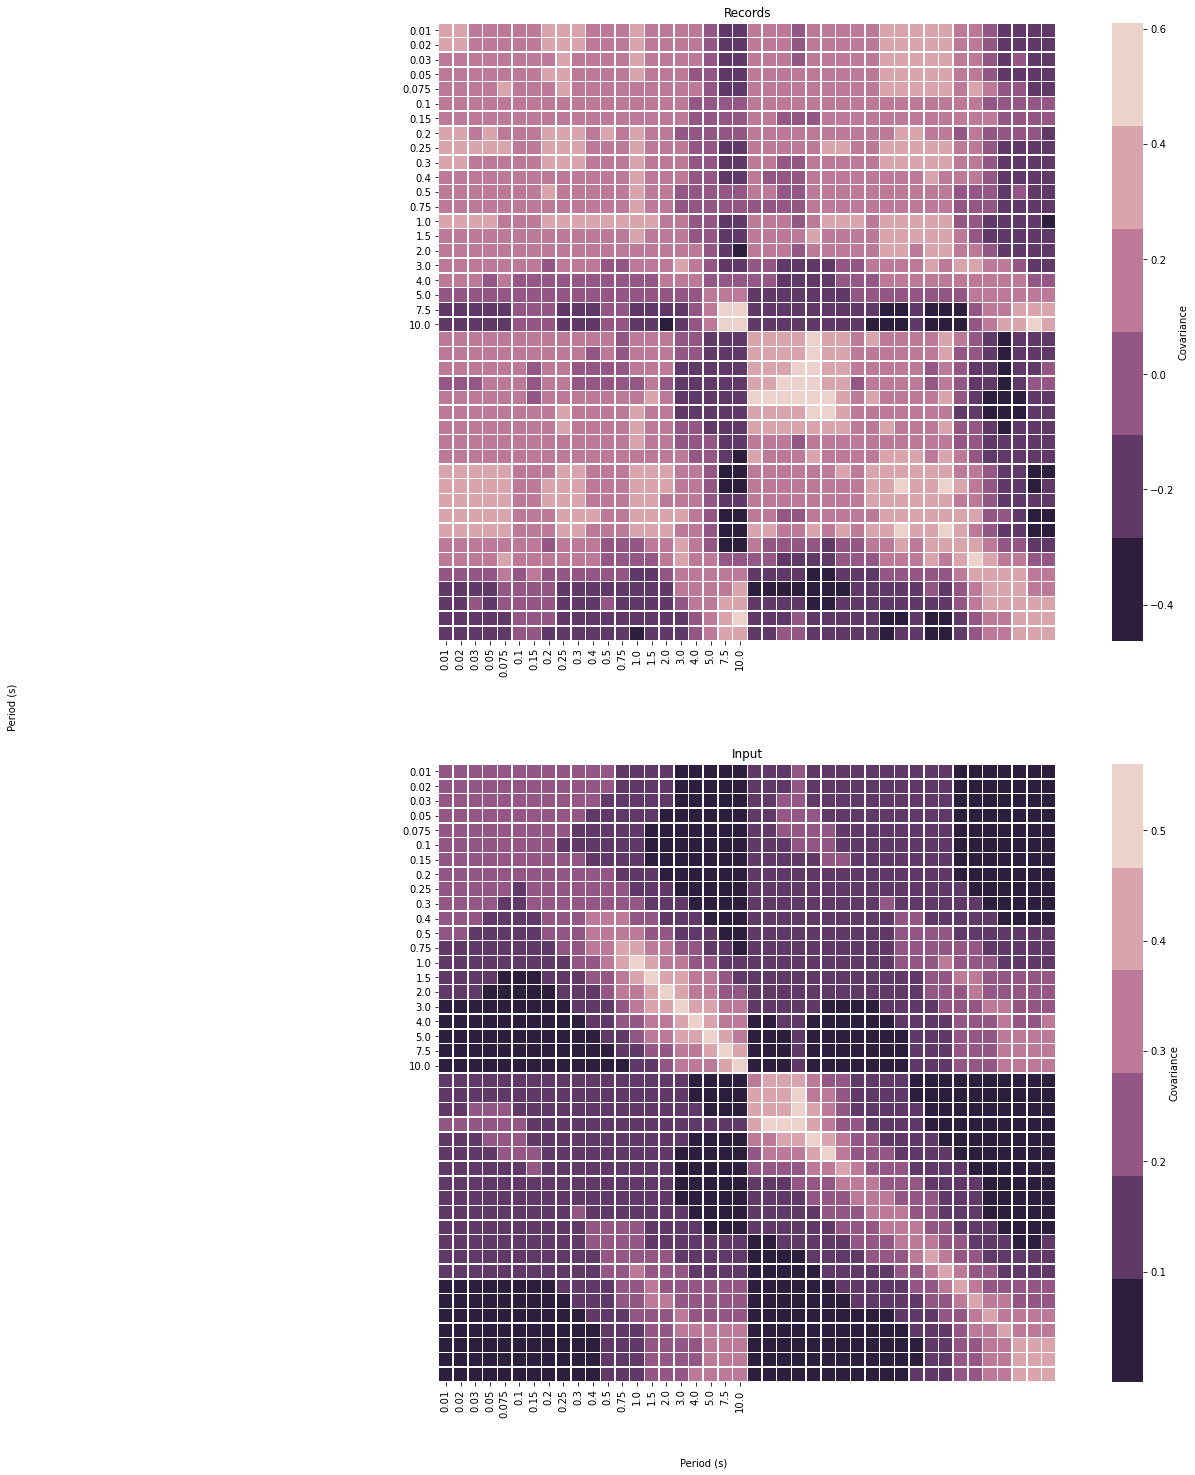

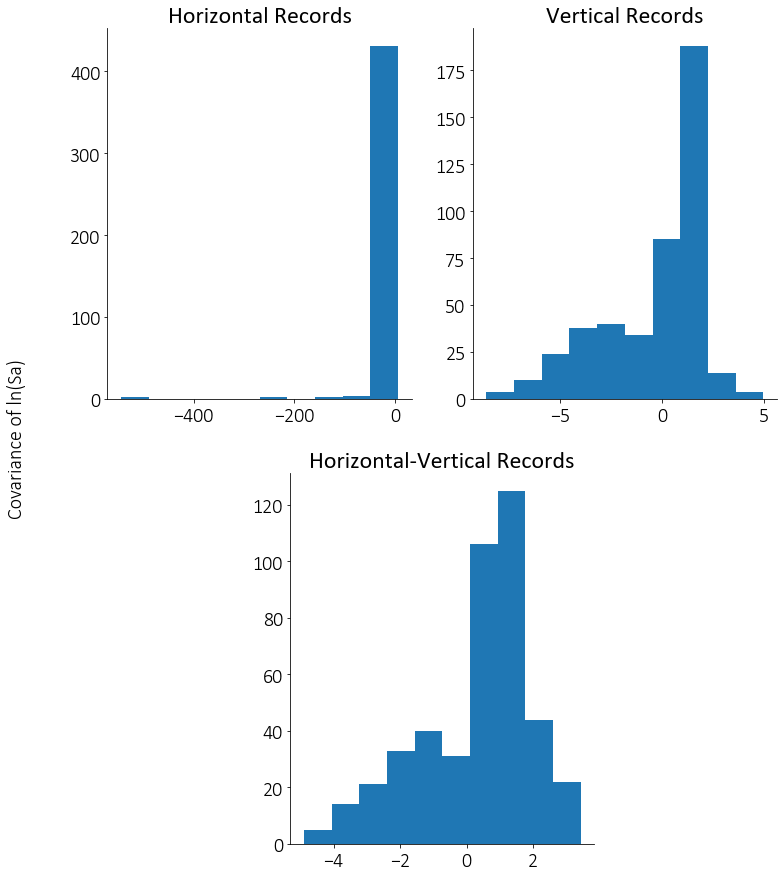

In [14]:
# Output information
finalRecords = recID
finalScaleFactors_H = finalScaleFac_H
finalScaleFactors_V = finalScaleFac_V

# Handling the error of not creating the output folder
if not os.path.isdir(SaveFolderPath):
    os.mkdir(SaveFolderPath)

#plot sample and target covariance matrices
corr_obs = np.zeros((2*len(meanReq_H),2*len(meanReq_H)))
corr_obs[:len(meanReq_H),:len(meanReq_H)] = np.cov(np.transpose(sampleSmall_H))
corr_obs[len(meanReq_H):,len(meanReq_H):] = np.cov(np.transpose(sampleSmall_V))
for i in range(len(meanReq_H)):
    for j in range(len(meanReq_H)):
        corr_obs[i,j+len(meanReq_H)] = np.cov(sampleSmall_H[:,i],sampleSmall_V[:,j])[0,1]
        corr_obs[j+len(meanReq_H),i] = corr_obs[i,j+len(meanReq_H)]
fig = plt.figure(figsize=(20,25))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
cmap = sns.cubehelix_palette(reverse=True)
ax1 = sns.heatmap(corr_obs, linewidth=0.5, xticklabels=PerTgt, yticklabels=PerTgt, ax=ax1, square = True, cmap=cmap, cbar_kws={'label': 'Covariance'})
ax2 = sns.heatmap(covariance_matrix, linewidth=0.5, xticklabels=PerTgt, yticklabels=PerTgt,ax=ax2, square = True, cmap=cmap, cbar_kws={'label': 'Covariance'})
ax1.set_title('Records')
ax2.set_title('Input')
#ax1.set_yticks(PerTgt*ax1.get_ylim()[1])
#ax1.set_xticks(PerTgt*ax1.get_xlim()[1])
fig.text(0.5, 0.08, 'Period (s)', ha='center', va='center')
fig.text(0.02, 0.5, 'Period (s)', ha='center', va='center', rotation='vertical')
fig.legend(bbox_to_anchor=(0.45,0.85),frameon=False)
font = {'family' : 'Calibri',
        'weight' : 100,
        'size'   : 20}
matplotlib.rc('font', **font)
plt.savefig(SaveFolderPath + '/' + "Sample and Target Covariance Matrices - " + OutputImagesSaveFileName + ".eps")

#plot histograms of covariance ratios
CovRatio = corr_obs/covariance_matrix
gs = matplotlib.gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(12,15))
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
# ax1.set_xlim([0, 20])
ax2 = plt.subplot(gs[0, 2:])
#ax2.set_xlim([0, 10])
ax3 = plt.subplot(gs[1, 1:3])
#ax3.set_xlim([0, 10])
ax1.set_title('Horizontal Records')
ax1.hist(np.hstack(CovRatio[:len(meanReq_H),:len(meanReq_H)]))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax2.set_title('Vertical Records')
ax2.hist(np.hstack(CovRatio[len(meanReq_H):,len(meanReq_H):]))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax3.set_title('Horizontal-Vertical Records')
ax3.hist(np.hstack(CovRatio[:len(meanReq_H),len(meanReq_H):]))
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
fig.text(0.02, 0.5, 'Covariance of ln(Sa)', ha='center', va='center', rotation='vertical')
font = {'family' : 'Calibri',
        'weight' : 100,
        'size'   : 20}
matplotlib.rc('font', **font)
plt.savefig(SaveFolderPath + '/' + "Histograms of covariance ratios - " + OutputImagesSaveFileName + ".eps")


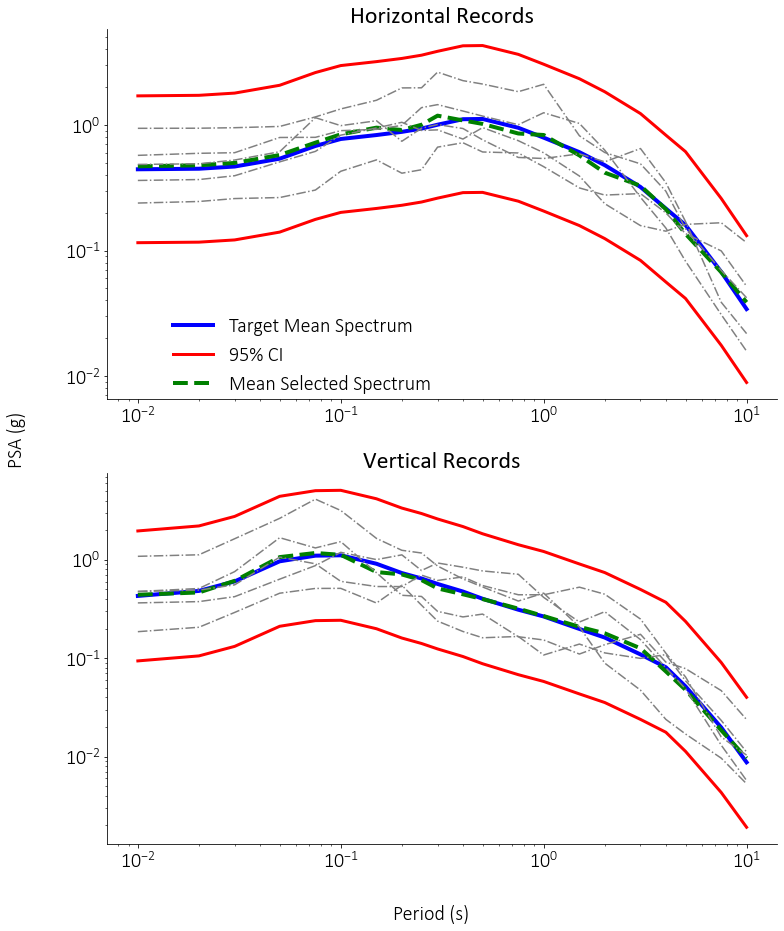

In [15]:
#plot sample and target Horizontal spectra
fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.loglog(PerTgt, np.exp(meanReq_H), color='blue', linestyle='-',linewidth=4, label='Target Mean Spectrum')
ax1.loglog(PerTgt, np.exp(meanReq_H+1.96*np.sqrt(np.diag(covReq_H))), color='red', linestyle='-',linewidth=3, label='95% CI')
ax1.loglog(PerTgt, np.exp(meanReq_H-1.96*np.sqrt(np.diag(covReq_H))), color='red', linestyle='-',linewidth=3)
ax1.loglog(PerTgt, np.exp(np.mean(sampleSmall_H,axis=0)), color='green', linestyle='--',linewidth=4, label='Mean Selected Spectrum')
ax1.loglog(PerTgt, np.exp(np.transpose(sampleSmall_H)), color='gray', linestyle='-.',linewidth=1.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax2.loglog(PerTgt, np.exp(meanReq_V), color='blue', linestyle='-',linewidth=4)
ax2.loglog(PerTgt, np.exp(meanReq_V+1.96*np.sqrt(np.diag(covReq_V))), color='red', linestyle='-',linewidth=3)
ax2.loglog(PerTgt, np.exp(meanReq_V-1.96*np.sqrt(np.diag(covReq_V))), color='red', linestyle='-',linewidth=3)
ax2.loglog(PerTgt, np.exp(np.mean(sampleSmall_V,axis=0)), color='green', linestyle='--',linewidth=4)
ax2.loglog(PerTgt, np.exp(np.transpose(sampleSmall_V)), color='gray', linestyle='-.',linewidth=1.5)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax1.set_title('Horizontal Records')
ax2.set_title('Vertical Records')
fig.text(0.5, 0.06, 'Period (s)', ha='center', va='center')
fig.text(0.02, 0.5, 'PSA (g)', ha='center', va='center', rotation='vertical')
fig.legend(bbox_to_anchor=(0.52,0.63),frameon=False)
font = {'family' : 'Calibri',
        'weight' : 100,
        'size'   : 20}
matplotlib.rc('font', **font)
plt.savefig(SaveFolderPath + '/' + "Sample and target spectra - " + OutputImagesSaveFileName + ".eps")

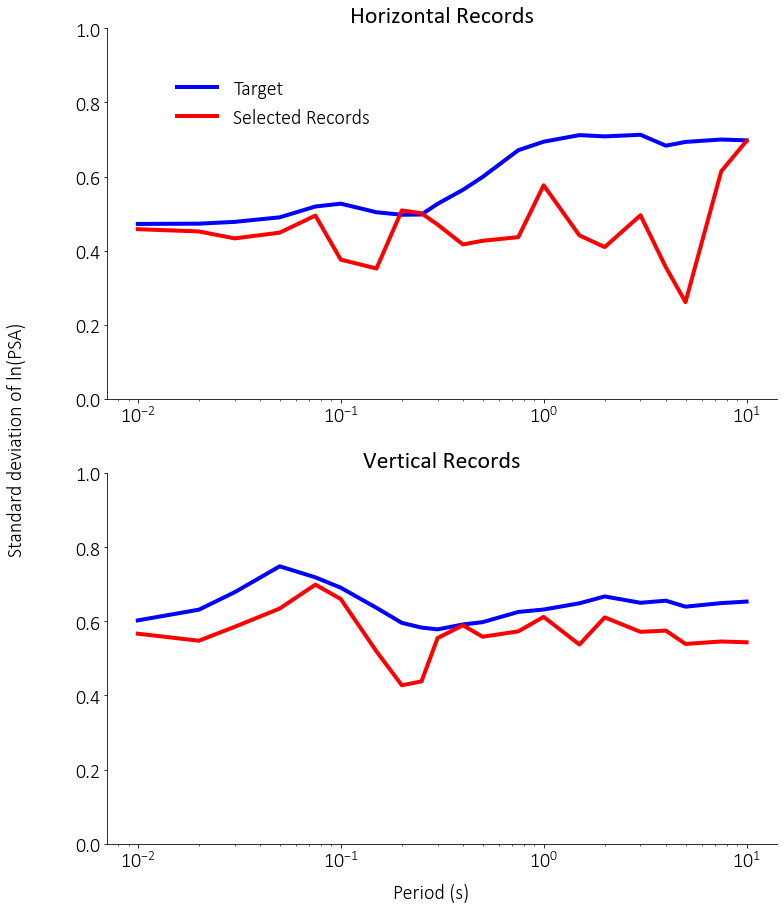

In [16]:
#plot sample and target standard deviations
fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.semilogx(PerTgt, np.sqrt(np.diag(covariance_matrix[:len(meanReq_H),:len(meanReq_H)])), color='blue', linestyle='-',linewidth=4, label='Target')
ax1.semilogx(PerTgt, np.std(sampleSmall_H,axis=0), color='red', linestyle='-',linewidth=4, label='Selected Records')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim([0, 1])
ax2.semilogx(PerTgt, np.sqrt(np.diag(covariance_matrix[len(meanReq_H):,len(meanReq_H):])), color='blue', linestyle='-',linewidth=4)
ax2.semilogx(PerTgt, np.std(sampleSmall_V,axis=0), color='red', linestyle='-',linewidth=4)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_ylim([0, 1])
ax1.set_title('Horizontal Records')
ax2.set_title('Vertical Records')
fig.text(0.5, 0.08, 'Period (s)', ha='center', va='center')
fig.text(0.02, 0.5, 'Standard deviation of ln(PSA)', ha='center', va='center', rotation='vertical')
fig.legend(bbox_to_anchor=(0.45,0.85),frameon=False)
font = {'family' : 'Calibri',
        'weight' : 100,
        'size'   : 20}
matplotlib.rc('font', **font)
plt.savefig(SaveFolderPath + '/' + "Sample and Target Standard Deviations - " + OutputImagesSaveFileName + ".eps")


# Output data to file (best viewed with textpad)
fh = open(SaveFolderPath + '/' + ListOfRecordsSaveFileName + '.txt', "w")
fh.write('%12s; %10s; %10s; %30s; %29s; %10s; %14s; %8s; %7s; %14s; %14s; \n' % ('Record Number','NGA EQID','RSN','EQ name','EQ station',
                                                               'Year','Magnitude','Rjb','Vs30','Scale Factor Hor',
                                                                'Scale Factor Ver'))

for j,i in enumerate(finalRecords):
    rec = int(i)
    fh.write('%12d; %11d; %10d; %30s; %32s; %7d; %15.2f; %8.2f; %8.1f; %9.2f; %9.2f; \n' % (j,EQID[rec],RSN[rec],
                                                                           str(EQ_name[rec]).strip(""'[]'""),
                                                                           str(station_name[rec]).strip(""'[]'""),
                                                                           EQ_year[rec],Magnitude[rec],Rjb[rec],
                                                                           soil_Vs30[rec],finalScaleFactors_H[j],
                                                                                finalScaleFactors_V[j]))

fh.close()

In [17]:
stop = timeit.default_timer()

print('Time (min): ', (stop - start)/60.0) 

Time (min):  2.5129511216666667


In [18]:
RSN_records = RSN[finalRecords]
fh = open(SaveFolderPath + '/' + ListOfRecordsSaveFileName +'_onlyRSN' + '.txt', "w")
Output_string = ','.join(str(x).strip("'[]'") for x in RSN_records)
fh.write('%s' % (Output_string))
fh.close() 